In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from pathlib import Path
from fastai.datasets import Config
import pandas as pd
import numpy as np
import seaborn as sns
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

import pickle
from tqdm import tqdm_notebook

import torch
import torchvision
import gc
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy

base_path = Config.data_path()
data_path = base_path/'Steel_Defects_Detection'

with open(data_path/'defect_labels.pickle', 'rb') as f:
    defects_labels = pickle.load(f)
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [3]:
samples = list(defects_labels.keys())
labels = list(defects_labels.values())

images_train, images_valid, labels_train, labels_valid = train_test_split(
    samples, 
    labels, 
    test_size=0.15,
    random_state=2019
)

In [17]:
# For fastai databunch creation
_df_source = {
    'image_name': samples,
    'has_defect': labels
}

defects_df = pd.DataFrame(_df_source)

In [19]:
len(defects_df)

12568

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
class SteelDefects_Dataset(Dataset):
    def __init__(self, images, labels, transforms, images_path=data_path/'train_images'):
        super().__init__()
        self.images_path = images_path
        self.images = images
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_name = self.images[idx]
#         label = torch.tensor(self.labels[idx])
        label = self.labels[idx]
        
        raw_image = Image.open(self.images_path/image_name)
        transformed_image = self.transforms(raw_image)
        
        return transformed_image, label

In [5]:
datasets = {
    'train': SteelDefects_Dataset(
        images=images_train,
        labels=labels_train,
        transforms=data_transforms['train']
        ),
    'valid': SteelDefects_Dataset(
        images=images_valid,
        labels=labels_valid,
        transforms=data_transforms['valid']
        )
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid']}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=64, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=128, shuffle=False)
}

tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1])


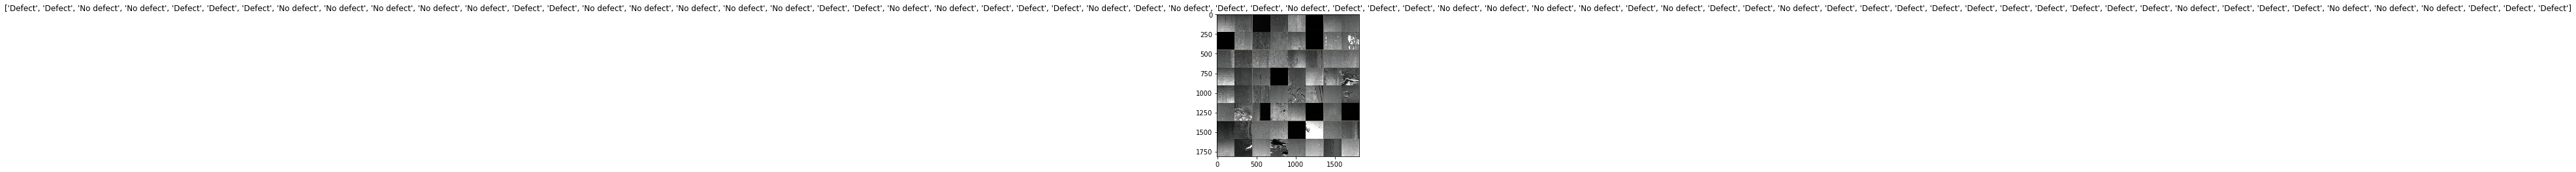

In [6]:
class_names = {
    0: 'No defect',
    1: 'Defect'
}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])

In [7]:
torch.tensor(1).item()

1

## Transfer learning

In [33]:
model = models.resnet50(pretrained=True)

In [22]:
model = models.resnet18(pretrained=False)

In [15]:
# Freeze model (all model parameters) first
for param in model.parameters():
    param.requires_grad = False

In [34]:
# Swap last (fully connected) layer with new no-trained-yet layer

fc_inputs = model.fc.in_features

model.fc = torch.nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2) 
#     nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm_notebook(range(num_epochs)):
        print(f"Epoch {epoch}", end="")

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(end="   || ")
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc), end="")

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print("-" * 10)
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [36]:
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
# optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0   || train Loss: 0.3031 Acc: 0.8644   || valid Loss: 0.5640 Acc: 0.8118
Epoch 1   || train Loss: 0.3015 Acc: 0.8640   || valid Loss: 0.5940 Acc: 0.8102
Epoch 2   || train Loss: 0.2961 Acc: 0.8661   || valid Loss: 0.5727 Acc: 0.8091
Epoch 3   || train Loss: 0.3005 Acc: 0.8629   || valid Loss: 0.5618 Acc: 0.8112
Epoch 4   || train Loss: 0.3028 Acc: 0.8658   || valid Loss: 0.5404 Acc: 0.8139
Epoch 5   || train Loss: 0.2972 Acc: 0.8729   || valid Loss: 0.5785 Acc: 0.8097
Epoch 6   || train Loss: 0.3029 Acc: 0.8677   || valid Loss: 0.5484 Acc: 0.8139
Epoch 7   || train Loss: 0.2996 Acc: 0.8658   || valid Loss: 0.5623 Acc: 0.8139
Epoch 8   || train Loss: 0.2977 Acc: 0.8671   || valid Loss: 0.5776 Acc: 0.8086
Epoch 9

## Fast AI Baseline

In [27]:
from fastai.vision import *
from fastai.metrics import error_rate

In [32]:
data = ImageDataBunch.from_df(df=defects_df, path=data_path/'train_images', size=64, suffix='', ds_tfms=get_transforms())

In [33]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

NameError: name 'cnn_learner' is not defined

In [2]:
from fastai.vision import cnn_learner

ImportError: cannot import name 'cnn_learner' from 'fastai.vision' (/opt/anaconda3/envs/kaggle_sandbox/lib/python3.7/site-packages/fastai/vision/__init__.py)

In [3]:
import fastai

In [4]:
fastai.__version__

'1.0.46'

In [6]:
!conda install -y fastai

Solving environment: done

# All requested packages already installed.

